In [1]:
import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader

import models.loadImg as loadImg
import models.modelsCNN as modelsCNN
import models.optimizer as optimizer

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc
from skimage import io
import scipy.stats
from sklearn.metrics import pairwise_distances

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
use_cuda=True
datadir='/media/xinyi/data'
name='exp0'
plotsavepath='/media/xinyi/plots/cnnvae'+name
sampledir=plotsavepath
clustersavedir_alltrain=os.path.join(sampledir,'cluster_alltrain_reordered')
ep=311
with open(os.path.join(datadir,'processed','train_cnnvae_names'), 'rb') as input:
    allImgNames=pickle.load(input)
#plot by disease progression
br1003aSpecs=pd.read_excel('/media/xinyi/data/BR1003a specs.xlsx',header=10)
br301Specs=pd.read_excel('/media/xinyi/data/BR301 specs.xlsx',header=10)
br8018aSpecs=pd.read_excel('/media/xinyi/data/BR8018a specs.xlsx',header=10)
br1003aSpecs.index=br1003aSpecs.loc[:,'Position']
br301Specs.index=br301Specs.loc[:,'Position']
br8018aSpecs.index=br8018aSpecs.loc[:,'Position']

progList=np.copy(allImgNames)
for s in np.unique(allImgNames):
    ssplit=s.split('_')
    if 'br1003a'==ssplit[0]:
        prog_s=br1003aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br301'==ssplit[0]:
        prog_s=br301Specs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br8018a'==ssplit[0]:
        prog_s=br8018aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    progList[allImgNames==s]=prog_s
    




In [3]:
metadata=pd.read_csv(os.path.join(datadir,'Supplementary Table 1_v1.csv'),header=0)
metadata.index=metadata.sample_id

In [4]:
allPatientIDs=np.repeat('none',allImgNames.size).astype(object)
for s in np.unique(allImgNames):
    sidx=allImgNames==s
    slideID=s.split('_')[0]
    coreID=s.split('_')[-1]
    allPatientIDs[sidx]=metadata.patient_id[slideID+'_'+str.lower(coreID)]

In [5]:
savenamesample='alltrain'

neworder=[1, 5, 3, 7, 2, 0, 4, 6]
#use chosen subcluster number and save plots
scanpy.settings.verbosity = 3
# subcluster=8
subclusterDict={0:[4],1:[6],2:[8],3:[6],4:[6],5:[6],6:[6],7:[4]}
ncluster=8

plotepoch=311
clusterplotdir=os.path.join(clustersavedir_alltrain,'plots')
n_pcs=50
savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
with open(os.path.join(clustersavedir_alltrain,'minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_all'), 'rb') as output:
    clusterRes=pickle.load(output)

kmeans_sub=(np.zeros(clusterRes.size)-1).astype(str)
savenameAdd='_plottingIdx_progBalanced_'+str(0)
subclusternumbers=[4,6,8,6,6,6,6,4]
savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+savenameAdd
for cnew in np.unique(clusterRes):
#     print('cluster'+str(c))
    c=neworder[cnew]
    
    subclustersavedir_alltrain=os.path.join(clustersavedir_alltrain,savenamecluster+'_subcluster'+str(c))
    with open(os.path.join(subclustersavedir_alltrain,'minibatchkmean_ncluster'+str(subclusternumbers[c])+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_all'), 'rb') as output:
        subclusterRes=pickle.load(output)
    print(np.unique(subclusterRes))
    kmeans_sub[clusterRes==cnew]=np.char.add(np.repeat(str(cnew)+'-',subclusterRes.size),subclusterRes.astype(str))
   

[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3]
[0 1 2 3 4 5 6 7]
[0 1 2 3]
[0 1 2 3 4 5]
[0 1 2 3 4 5]


In [6]:
with open(os.path.join(datadir,'processed','train_cnnvae_coord'), 'rb') as output:
    coordlist=pickle.load(output)

In [7]:
for p in np.unique(progList):
    if p=='Ductal carcinoma in situ':
        progList[progList==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ and breast tissue':
        progList[progList==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ with early infiltratio':
        progList[progList==p]='DCIS with early infiltration'
    
    elif p=='Micropapillary type ductal carcinoma in situ wi':
        progList[progList==p]='DCIS with early infiltration'    
#     elif p=='Atypical hyperlasia':
#         progList[progList==p]='Hyperplasia'

In [8]:
progInclude=np.array(['Breast tissue','Cancer adjacent normal breast tissue','Hyperplasia','Atypical hyperplasia','DCIS and breast tissue',  'DCIS with early infiltration','Invasive ductal carcinoma and breast tissue','Invasive ductal carcinoma'])

In [9]:
progIncludeIdx=np.repeat(False,progList.size)
for p in progInclude:
    progIncludeIdx[progList==p]=True
    
coordlist=coordlist[progIncludeIdx]
allImgNames=allImgNames[progIncludeIdx]
clusterRes=clusterRes[progIncludeIdx]
kmeans_sub=kmeans_sub[progIncludeIdx]
progList=progList[progIncludeIdx]

In [10]:
sUnique,sidx_start=np.unique(allImgNames,return_index=True)
progUnique,labels_train,progCounts=np.unique(progList[sidx_start],return_counts=True,return_inverse=True)
for p in range(progUnique.size):
    print(progUnique[p])
    print(progCounts[p])

Atypical hyperplasia
14
Breast tissue
20
Cancer adjacent normal breast tissue
13
DCIS and breast tissue
16
DCIS with early infiltration
30
Hyperplasia
41
Invasive ductal carcinoma
70
Invasive ductal carcinoma and breast tissue
8


In [11]:
#get cluster composition
clusterUnique=np.unique(clusterRes)
subclusterUnique=np.unique(kmeans_sub)
inputCluster=np.zeros((sUnique.size,clusterUnique.size))
inputSubcluster=np.zeros((sUnique.size,subclusterUnique.size))
for i in range(sUnique.size):
    clusterRes_i=clusterRes[allImgNames==sUnique[i]]
    kmeans_sub_i=kmeans_sub[allImgNames==sUnique[i]]
    for j in range(clusterUnique.size):
        inputCluster[i,j]=np.sum(clusterRes_i==clusterUnique[j])
    for j in range(subclusterUnique.size):
        inputSubcluster[i,j]=np.sum(kmeans_sub_i==subclusterUnique[j])
inputCluster=inputCluster/np.sum(inputCluster,axis=1,keepdims=True)
inputSubcluster=inputSubcluster/np.sum(inputSubcluster,axis=1,keepdims=True)

In [12]:
def getHistMatrix_clusters(labels,ctlist,nrow=ncluster,ncol=ncluster):
    res=np.zeros((nrow,ncol))
    for li in range(res.shape[0]):
        l=li
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=ci
            res[l,c]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
        if nl!=0:
            res[li]=res[li]/nl
    return res

neighborhoodSize=16*9

In [13]:
#get neighborhood composition

inputNeighborhood=np.zeros((sUnique.size,ncluster*ncluster))
for i in range(sUnique.size):
    imgN=sUnique[i]
    nsamples=np.sum(allImgNames==imgN)
    cluster_i=clusterRes[allImgNames==imgN]
    neighbor_i=np.tile(cluster_i,(nsamples,1))
    self_i=np.tile(cluster_i.reshape((-1,1)),(1,nsamples))

    dist=pairwise_distances(coordlist[allImgNames==imgN],n_jobs=-1)
    distIn=np.logical_and(dist<neighborhoodSize,dist>0)
    res=getHistMatrix_clusters(self_i[distIn],neighbor_i[distIn])
    
    inputNeighborhood[i]=res.flatten()

In [14]:
_,inputCounts=np.unique(allImgNames,return_counts=True)
inputAll=np.concatenate((np.concatenate((inputCluster,inputSubcluster),axis=1),np.concatenate((inputNeighborhood,inputCounts.reshape(-1,1)),axis=1)),axis=1)

In [15]:
#val cores (as validation cores) and val samples (as test cores)
clustersavedir_valcores=os.path.join(sampledir,'cluster_valcores_reordered')
clustersavedir_valsamples=os.path.join(sampledir,'cluster_valsamples_reordered')

with open(os.path.join(datadir,'processed','train_cnnvae_coord_valcores'), 'rb') as output:
    coordlist_valcores=pickle.load(output)
with open(os.path.join(datadir,'processed','train_cnnvae_coord_valsamples'), 'rb') as output:
    coordlist_valsamples=pickle.load(output)

savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
with open(os.path.join(clustersavedir_valcores,savenamecluster+'_all'), 'rb') as output:
    clusterRes_valcores=pickle.load(output)
with open(os.path.join(clustersavedir_valsamples,'minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_all'), 'rb') as output:
    clusterRes_valsamples=pickle.load(output)
    
kmeans_sub_valcores=(np.zeros(clusterRes_valcores.size)-1).astype(str)
for c in np.unique(clusterRes_valcores):
    subclustersavedir=os.path.join(clustersavedir_valcores,savenamecluster+'_plottingIdx_progBalanced_'+str(0)+'_subcluster'+str(neworder[c]))
    with open(os.path.join(subclustersavedir,'minibatchkmean_ncluster'+str(subclusterDict[neworder[c]][0])+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_all'), 'rb') as output:
        subclusterRes=pickle.load(output)
    kmeans_sub_valcores[clusterRes_valcores==c]=np.char.add(np.repeat(str(c)+'-',subclusterRes.size),subclusterRes.astype(str))
    
kmeans_sub_valsamples=(np.zeros(clusterRes_valsamples.size)-1).astype(str)
for c in np.unique(clusterRes_valsamples):
    subclustersavedir=os.path.join(clustersavedir_valsamples,savenamecluster+'_plottingIdx_progBalanced_'+str(0)+'_subcluster'+str(neworder[c]))
    with open(os.path.join(subclustersavedir,'minibatchkmean_ncluster'+str(subclusterDict[neworder[c]][0])+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_all'), 'rb') as output:
        subclusterRes=pickle.load(output)
    kmeans_sub_valsamples[clusterRes_valsamples==c]=np.char.add(np.repeat(str(c)+'-',subclusterRes.size),subclusterRes.astype(str))
                

In [16]:
with open(os.path.join(datadir,'processed','train_cnnvae_names_valcores'), 'rb') as input:
    allImgNames_valcores=pickle.load(input)
with open(os.path.join(datadir,'processed','train_cnnvae_names_valsamples'), 'rb') as input:
    allImgNames_valsamples=pickle.load(input)

In [17]:
#plot by disease progression
br1003aSpecs=pd.read_excel('/media/xinyi/data/BR1003a specs.xlsx',header=10)
br301Specs=pd.read_excel('/media/xinyi/data/BR301 specs.xlsx',header=10)
br8018aSpecs=pd.read_excel('/media/xinyi/data/BR8018a specs.xlsx',header=10)
br1003aSpecs.index=br1003aSpecs.loc[:,'Position']
br301Specs.index=br301Specs.loc[:,'Position']
br8018aSpecs.index=br8018aSpecs.loc[:,'Position']

progList_valcores=np.copy(allImgNames_valcores)
for s in np.unique(allImgNames_valcores):
    ssplit=s.split('_')
    if 'br1003a'==ssplit[0]:
        prog_s=br1003aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br301'==ssplit[0]:
        prog_s=br301Specs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br8018a'==ssplit[0]:
        prog_s=br8018aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    progList_valcores[allImgNames_valcores==s]=prog_s
    
progList_valsamples=np.copy(allImgNames_valsamples)
for s in np.unique(allImgNames_valsamples):
    ssplit=s.split('_')
    if 'br1003a'==ssplit[0]:
        prog_s=br1003aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br301'==ssplit[0]:
        prog_s=br301Specs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br8018a'==ssplit[0]:
        prog_s=br8018aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    progList_valsamples[allImgNames_valsamples==s]=prog_s
    



In [18]:
np.unique(progList_valsamples)


array(['Atypical hyperplasia', 'Breast tissue',
       'Cancer adjacent normal breast tissue', 'Ductal carcinoma in situ',
       'Ductal carcinoma in situ and breast tissue',
       'Ductal carcinoma in situ with early infiltrati', 'Hyperplasia',
       'Hyperplasia with saccular dilatation',
       'Invasive ductal carcinoma',
       'Invasive ductal carcinoma (breast tissue)',
       'Invasive ductal carcinoma and breast tissue',
       'Micropapillary type ductal carcinoma in situ w'], dtype='<U46')

In [19]:
for p in np.unique(progList_valcores):
    if p=='Ductal carcinoma in situ':
        progList_valcores[progList_valcores==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ and breast tissue':
        progList_valcores[progList_valcores==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ with early infiltratio':
        progList_valcores[progList_valcores==p]='DCIS with early infiltration'
    
    elif p=='Micropapillary type ductal carcinoma in situ wi':
        progList_valcores[progList_valcores==p]='DCIS with early infiltration'    
#     elif p=='Atypical hyperlasia':
#         progList_valcores[progList_valcores==p]='Hyperplasia'

In [20]:
for p in np.unique(progList_valsamples):
    if p=='Ductal carcinoma in situ':
        progList_valsamples[progList_valsamples==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ and breast tissue':
        progList_valsamples[progList_valsamples==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ with early infiltrati':
        progList_valsamples[progList_valsamples==p]='DCIS with early infiltration'
    
    elif p=='Micropapillary type ductal carcinoma in situ w':
        progList_valsamples[progList_valsamples==p]='DCIS with early infiltration'    
#     elif p=='Atypical hyperlasia':
#         progList_valsamples[progList_valsamples==p]='Hyperplasia'

In [21]:
progIncludeIdx_valcores=np.repeat(False,progList_valcores.size)
for p in progInclude:
    progIncludeIdx_valcores[progList_valcores==p]=True
    
progIncludeIdx_valsamples=np.repeat(False,progList_valsamples.size)
for p in progInclude:
    progIncludeIdx_valsamples[progList_valsamples==p]=True
    
coordlist_valcores=coordlist_valcores[progIncludeIdx_valcores]
allImgNames_valcores=allImgNames_valcores[progIncludeIdx_valcores]
clusterRes_valcores=clusterRes_valcores[progIncludeIdx_valcores]
kmeans_sub_valcores=kmeans_sub_valcores[progIncludeIdx_valcores]
progList_valcores=progList_valcores[progIncludeIdx_valcores]

coordlist_valsamples=coordlist_valsamples[progIncludeIdx_valsamples]
allImgNames_valsamples=allImgNames_valsamples[progIncludeIdx_valsamples]
clusterRes_valsamples=clusterRes_valsamples[progIncludeIdx_valsamples]
kmeans_sub_valsamples=kmeans_sub_valsamples[progIncludeIdx_valsamples]
progList_valsamples=progList_valsamples[progIncludeIdx_valsamples]


In [22]:
sUnique_valcores,sidx_start_valcores=np.unique(allImgNames_valcores,return_index=True)
progUnique_valcores,progCounts_valcores=np.unique(progList_valcores[sidx_start_valcores],return_counts=True)
for p in range(progUnique_valcores.size):
    print(progUnique_valcores[p])
    print(progCounts_valcores[p])

Atypical hyperplasia
15
Breast tissue
20
Cancer adjacent normal breast tissue
1
Hyperplasia
35
Invasive ductal carcinoma
97


In [23]:
sUnique_valsamples,sidx_start_valsamples=np.unique(allImgNames_valsamples,return_index=True)
progUnique_valsamples,progCounts_valsamples=np.unique(progList_valsamples[sidx_start_valsamples],return_counts=True)
for p in range(progUnique_valsamples.size):
    print(progUnique_valsamples[p])
    print(progCounts_valsamples[p])

Atypical hyperplasia
10
Breast tissue
14
Cancer adjacent normal breast tissue
4
DCIS and breast tissue
16
DCIS with early infiltration
29
Hyperplasia
25
Invasive ductal carcinoma
66
Invasive ductal carcinoma and breast tissue
8


In [24]:
#construct labels
labels_valcores=np.zeros(progList_valcores[sidx_start_valcores].size)
for i in range(progUnique.size):
    labels_valcores[progList_valcores[sidx_start_valcores]==progUnique[i]]=i

In [25]:
#construct labels
labels_valsamples=np.zeros(progList_valsamples[sidx_start_valsamples].size)
for i in range(progUnique.size):
    labels_valsamples[progList_valsamples[sidx_start_valsamples]==progUnique[i]]=i

In [26]:
#get cluster composition
inputCluster_valcores=np.zeros((sUnique_valcores.size,clusterUnique.size))
inputSubcluster_valcores=np.zeros((sUnique_valcores.size,subclusterUnique.size))
for i in range(sUnique_valcores.size):
    clusterRes_i=clusterRes_valcores[allImgNames_valcores==sUnique_valcores[i]]
    kmeans_sub_i=kmeans_sub_valcores[allImgNames_valcores==sUnique_valcores[i]]
    for j in range(clusterUnique.size):
        inputCluster_valcores[i,j]=np.sum(clusterRes_i==clusterUnique[j])
    for j in range(subclusterUnique.size):
        inputSubcluster_valcores[i,j]=np.sum(kmeans_sub_i==subclusterUnique[j])
inputCluster_valcores=inputCluster_valcores/np.sum(inputCluster_valcores,axis=1,keepdims=True)
inputSubcluster_valcores=inputSubcluster_valcores/np.sum(inputSubcluster_valcores,axis=1,keepdims=True)

In [27]:
#get cluster composition
inputCluster_valsamples=np.zeros((sUnique_valsamples.size,clusterUnique.size))
inputSubcluster_valsamples=np.zeros((sUnique_valsamples.size,subclusterUnique.size))
for i in range(sUnique_valsamples.size):
    clusterRes_i=clusterRes_valsamples[allImgNames_valsamples==sUnique_valsamples[i]]
    kmeans_sub_i=kmeans_sub_valsamples[allImgNames_valsamples==sUnique_valsamples[i]]
    for j in range(clusterUnique.size):
        inputCluster_valsamples[i,j]=np.sum(clusterRes_i==clusterUnique[j])
    for j in range(subclusterUnique.size):
        inputSubcluster_valsamples[i,j]=np.sum(kmeans_sub_i==subclusterUnique[j])
inputCluster_valsamples=inputCluster_valsamples/np.sum(inputCluster_valsamples,axis=1,keepdims=True)
inputSubcluster_valsamples=inputSubcluster_valsamples/np.sum(inputSubcluster_valsamples,axis=1,keepdims=True)

In [28]:
inputNeighborhood_valcores=np.zeros((sUnique_valcores.size,ncluster*ncluster))
for i in range(sUnique_valcores.size):
    imgN=sUnique_valcores[i]
    nsamples=np.sum(allImgNames_valcores==imgN)
    cluster_i=clusterRes_valcores[allImgNames_valcores==imgN]
    neighbor_i=np.tile(cluster_i,(nsamples,1))
    self_i=np.tile(cluster_i.reshape((-1,1)),(1,nsamples))

    dist=pairwise_distances(coordlist_valcores[allImgNames_valcores==imgN],n_jobs=-1)
    distIn=np.logical_and(dist<neighborhoodSize,dist>0)
    res=getHistMatrix_clusters(self_i[distIn],neighbor_i[distIn])
    
    inputNeighborhood_valcores[i]=res.flatten()

In [29]:
inputNeighborhood_valsamples=np.zeros((sUnique_valsamples.size,ncluster*ncluster))
for i in range(sUnique_valsamples.size):
    imgN=sUnique_valsamples[i]
    nsamples=np.sum(allImgNames_valsamples==imgN)
    cluster_i=clusterRes_valsamples[allImgNames_valsamples==imgN]
    neighbor_i=np.tile(cluster_i,(nsamples,1))
    self_i=np.tile(cluster_i.reshape((-1,1)),(1,nsamples))

    dist=pairwise_distances(coordlist_valsamples[allImgNames_valsamples==imgN],n_jobs=-1)
    distIn=np.logical_and(dist<neighborhoodSize,dist>0)
    res=getHistMatrix_clusters(self_i[distIn],neighbor_i[distIn])
    
    inputNeighborhood_valsamples[i]=res.flatten()

In [30]:
_,inputCounts_valcores=np.unique(allImgNames_valcores,return_counts=True)
inputAll_valcores=np.concatenate((np.concatenate((inputCluster_valcores,inputSubcluster_valcores),axis=1),np.concatenate((inputNeighborhood_valcores,inputCounts_valcores.reshape(-1,1)),axis=1)),axis=1)

In [31]:
_,inputCounts_valsamples=np.unique(allImgNames_valsamples,return_counts=True)
inputAll_valsamples=np.concatenate((np.concatenate((inputCluster_valsamples,inputSubcluster_valsamples),axis=1),np.concatenate((inputNeighborhood_valsamples,inputCounts_valsamples.reshape(-1,1)),axis=1)),axis=1)

In [32]:
allPatientIDs_valcores=np.repeat('none',allImgNames_valcores.size).astype(object)
for s in np.unique(allImgNames_valcores):
    sidx=allImgNames_valcores==s
    slideID=s.split('_')[0]
    coreID=s.split('_')[-1]
    allPatientIDs_valcores[sidx]=metadata.patient_id[slideID+'_'+str.lower(coreID)]

In [33]:
allPatientIDs_valsamples=np.repeat('none',allImgNames_valsamples.size).astype(object)
for s in np.unique(allImgNames_valsamples):
    sidx=allImgNames_valsamples==s
    slideID=s.split('_')[0]
    coreID=s.split('_')[-1]
    allPatientIDs_valsamples[sidx]=metadata.patient_id[slideID+'_'+str.lower(coreID)]

In [35]:
#img sizes
allImgNamesAll=np.concatenate((allImgNames,np.concatenate((allImgNames_valcores,allImgNames_valsamples))))
progListAll=np.concatenate((progList,np.concatenate((progList_valcores,progList_valsamples))))
sidxAll=np.concatenate((sidx_start,np.concatenate((sidx_start_valcores,sidx_start_valsamples))))
coordlistAll=np.concatenate((coordlist,np.concatenate((coordlist_valcores,coordlist_valsamples),axis=0)),axis=0)

imgSizeAll={}
for p in progUnique:
    img_cores=allImgNamesAll[sidxAll[progListAll[sidxAll]==p]]
    pSizes=np.zeros((img_cores.size))
    for si in range(img_cores.size):
        scoord=coordlistAll[allImgNamesAll==img_cores[si]]
        hsize=np.pi*np.square(np.max(scoord[:,0])-np.min(scoord[:,0]))
        vsize=np.pi*np.square(np.max(scoord[:,1])-np.min(scoord[:,1]))
        pSizes[si]=min(hsize,vsize)
    imgSizeAll[p]=pSizes

([<matplotlib.axis.XTick at 0x7f836c2bb070>,
 [Text(1, 0, 'Atypical hyperplasia'),
  Text(2, 0, 'Breast tissue'),
  Text(3, 0, 'Cancer adjacent normal breast tissue'),
  Text(4, 0, 'DCIS and breast tissue'),
  Text(5, 0, 'DCIS with early infiltration'),
  Text(6, 0, 'Hyperplasia'),
  Text(7, 0, 'Invasive ductal carcinoma'),
  Text(8, 0, 'Invasive ductal carcinoma and breast tissue')])

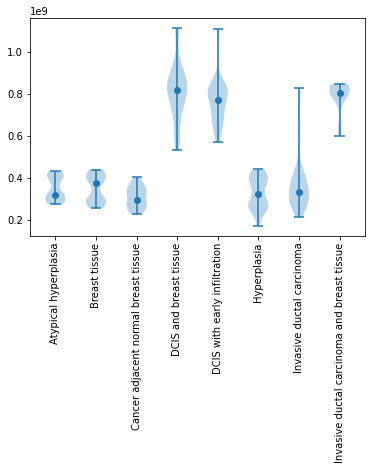

In [36]:
imgSize_median={}
for p in progUnique:
    imgSize_median[p]=np.median(imgSizeAll[p])
plt.violinplot(list(imgSizeAll.values()))
plt.scatter(np.arange(progUnique.size)+1,list(imgSize_median.values()))
plt.xticks(np.arange(progUnique.size)+1,list(imgSizeAll),rotation=90)

In [37]:
with open(os.path.join(datadir,'processed','imgSizeByPath'), 'wb') as output:
    pickle.dump(imgSize_median,output,pickle.HIGHEST_PROTOCOL)

In [38]:
#normalize count
with open(os.path.join(datadir,'processed','imgSizeByPath'), 'rb') as output:
    imgSize_median=pickle.load(output)
area_train=np.zeros(labels_train.size)
for s in range(labels_train.size):
    area_train[s]=imgSize_median[progUnique[labels_train.astype(int)][s]]
inputAll[:,-1]=inputAll[:,-1]/area_train

In [39]:
area_valcores=np.zeros(labels_valcores.size)
for s in range(labels_valcores.size):
    area_valcores[s]=imgSize_median[progUnique[labels_valcores.astype(int)][s]]
inputAll_valcores[:,-1]=inputAll_valcores[:,-1]/area_valcores

In [40]:
area_valsamples=np.zeros(labels_valsamples.size)
for s in range(labels_valsamples.size):
    area_valsamples[s]=imgSize_median[progUnique[labels_valsamples.astype(int)][s]]
inputAll_valsamples[:,-1]=inputAll_valsamples[:,-1]/area_valsamples

In [41]:
#concatenate cores
inputAll=np.concatenate((inputAll,np.concatenate((inputAll_valcores,inputAll_valsamples),axis=0)),axis=0)
imgNamesAll=np.concatenate((allImgNames[sidx_start],np.concatenate((allImgNames_valcores[sidx_start_valcores],allImgNames_valsamples[sidx_start_valsamples]))))
labelsAll=np.concatenate((labels_train,np.concatenate((labels_valcores,labels_valsamples))))

In [42]:
_,progCountsAll=np.unique(labelsAll,return_counts=True)
weights_train=np.sum(progCountsAll)/progCountsAll

In [43]:
seed=3
epochs=6000
saveFreq=200
lr=0.001 #initial learning rate
weight_decay=0 

# batchsize=4
batchsize=6000
model_str='fc3'

fc_dim1=64
fc_dim2=64
fc_dim3=64


dropout=0.01

name='exp0_pathologyClf_neighbor_clusters_exp0_subset_countAreaNorm_crossVal_wAH_byPatientCorr'
logsavepath='/media/xinyi/log/cnnvae'+name
modelsavepath='/media/xinyi/models/cnnvae'+name
plotsavepath='/media/xinyi/plots/cnnvae'+name


if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)



In [44]:
inputAll=scipy.stats.zscore(inputAll,axis=0)

In [45]:
def train(epoch,trainInput,labels_train):
    t = time.time()
    model.train()
    optimizer.zero_grad()

    pred = model(trainInput)

    loss=lossCE(pred,labels_train)

    loss.backward()
    optimizer.step()

    if epoch%500==0:
        print('Epoch: {:04d}'.format(epoch),
              'loss_train: {:.4f}'.format(loss))
    return loss.item()

In [46]:
allPatientIDs=np.concatenate((allPatientIDs,np.concatenate((allPatientIDs_valcores,allPatientIDs_valsamples))))
pIDList=allPatientIDs[np.concatenate((sidx_start,np.concatenate((sidx_start_valcores,sidx_start_valsamples))))]


In [47]:
inputAll=torch.tensor(inputAll).cuda().float()
labelsAll=torch.tensor(labelsAll).cuda().long()

testepoch=5000
predtest=np.zeros((inputAll.shape[0],np.unique(labels_train).size))
for patientIDX in range(np.unique(pIDList).size):
    patientID=np.unique(pIDList)[patientIDX]
    sampleIdx=np.arange(inputAll.shape[0])[pIDList==patientID]
    trainIdx=np.arange(inputAll.shape[0])[pIDList!=patientID]
    
    seed=3
    torch.manual_seed(seed)
    nclasses=np.unique(labels_train).size
    if use_cuda:
        torch.cuda.manual_seed(seed)

    nfeatures=inputAll.shape[1]
    if model_str=='fc3':
        model = modelsCNN.FC_l3(nfeatures,fc_dim1,fc_dim2,fc_dim3,nclasses,0.5,regrs=False)
        lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weights_train).cuda().float())
    if model_str=='fc5':
        model = modelsCNN.FC_l5(nfeatures,fc_dim1,fc_dim2,fc_dim3,fc_dim4,fc_dim5,nclasses,0.5,regrs=False)
        lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weights_train).cuda().float())
    if model_str=='fc1':
        model = modelsCNN.FC_l1(nfeatures,fc_dim1,nclasses,regrs=False)
        lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weights_train).cuda().float())
    if model_str=='fc0':
        model = modelsCNN.FC_l0(nfeatures,nclasses,regrs=False)
        lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weights_train).cuda().float())

    if use_cuda:
        model.cuda()

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_loss_ep=[None]*epochs
    val_loss_ep=[None]*epochs
    t_ep=time.time()

    for ep in range(epochs):
        train_loss_ep[ep]=train(ep,inputAll[trainIdx],labelsAll[trainIdx])


        if ep%saveFreq == 0 and ep!=0:
            torch.save(model.cpu().state_dict(), os.path.join(modelsavepath,patientID+'_'+str(ep)+'.pt'))
        if use_cuda:
            model.cuda()
            torch.cuda.empty_cache()
    print(' total time: {:.4f}s'.format(time.time() - t_ep))

    with open(os.path.join(logsavepath,patientID+'_train_loss'), 'wb') as output:
        pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)

    model.load_state_dict(torch.load(os.path.join(modelsavepath,patientID+'_'+str(testepoch)+'.pt')))
    with torch.no_grad():
        model.cuda()
        model.eval()
        pred = model(inputAll[sampleIdx])
        predtest[sampleIdx]=pred.cpu().detach().numpy()

        loss_test=lossCE(pred,labelsAll[sampleIdx]).item()

    print(loss_test)

Epoch: 0000 loss_train: 2.0845
Epoch: 0500 loss_train: 0.3124
Epoch: 1000 loss_train: 0.1235
Epoch: 1500 loss_train: 0.0655
Epoch: 2000 loss_train: 0.1163
Epoch: 2500 loss_train: 0.0522
Epoch: 3000 loss_train: 0.0519
Epoch: 3500 loss_train: 0.0474
Epoch: 4000 loss_train: 0.0306
Epoch: 4500 loss_train: 0.0598
Epoch: 5000 loss_train: 0.0306
Epoch: 5500 loss_train: 0.0225
 total time: 7.9468s
5.585275173187256
Epoch: 0000 loss_train: 2.0905
Epoch: 0500 loss_train: 0.2647
Epoch: 1000 loss_train: 0.1988
Epoch: 1500 loss_train: 0.0592
Epoch: 2000 loss_train: 0.0874
Epoch: 2500 loss_train: 0.0754
Epoch: 3000 loss_train: 0.0760
Epoch: 3500 loss_train: 0.0388
Epoch: 4000 loss_train: 0.0377
Epoch: 4500 loss_train: 0.0173
Epoch: 5000 loss_train: 0.0278
Epoch: 5500 loss_train: 0.0378
 total time: 7.5403s
0.0721595510840416
Epoch: 0000 loss_train: 2.0865
Epoch: 0500 loss_train: 0.3091
Epoch: 1000 loss_train: 0.1479
Epoch: 1500 loss_train: 0.0585
Epoch: 2000 loss_train: 0.0569
Epoch: 2500 loss_train

Epoch: 0500 loss_train: 0.2816
Epoch: 1000 loss_train: 0.1437
Epoch: 1500 loss_train: 0.0652
Epoch: 2000 loss_train: 0.1072
Epoch: 2500 loss_train: 0.1263
Epoch: 3000 loss_train: 0.0580
Epoch: 3500 loss_train: 0.0510
Epoch: 4000 loss_train: 0.0258
Epoch: 4500 loss_train: 0.0495
Epoch: 5000 loss_train: 0.0509
Epoch: 5500 loss_train: 0.0128
 total time: 7.5430s
1.1920925402364446e-07
Epoch: 0000 loss_train: 2.0826
Epoch: 0500 loss_train: 0.2774
Epoch: 1000 loss_train: 0.1320
Epoch: 1500 loss_train: 0.0872
Epoch: 2000 loss_train: 0.0761
Epoch: 2500 loss_train: 0.0468
Epoch: 3000 loss_train: 0.0404
Epoch: 3500 loss_train: 0.0188
Epoch: 4000 loss_train: 0.0347
Epoch: 4500 loss_train: 0.0461
Epoch: 5000 loss_train: 0.0279
Epoch: 5500 loss_train: 0.0360
 total time: 7.5246s
12.256543159484863
Epoch: 0000 loss_train: 2.0908
Epoch: 0500 loss_train: 0.2880
Epoch: 1000 loss_train: 0.1816
Epoch: 1500 loss_train: 0.0531
Epoch: 2000 loss_train: 0.0745
Epoch: 2500 loss_train: 0.0586
Epoch: 3000 loss_

Epoch: 0500 loss_train: 0.2383
Epoch: 1000 loss_train: 0.1146
Epoch: 1500 loss_train: 0.0594
Epoch: 2000 loss_train: 0.0881
Epoch: 2500 loss_train: 0.0765
Epoch: 3000 loss_train: 0.0591
Epoch: 3500 loss_train: 0.0403
Epoch: 4000 loss_train: 0.0378
Epoch: 4500 loss_train: 0.0194
Epoch: 5000 loss_train: 0.0215
Epoch: 5500 loss_train: 0.0417
 total time: 7.5022s
9.946769714355469
Epoch: 0000 loss_train: 2.0846
Epoch: 0500 loss_train: 0.2950
Epoch: 1000 loss_train: 0.1138
Epoch: 1500 loss_train: 0.0773
Epoch: 2000 loss_train: 0.0905
Epoch: 2500 loss_train: 0.0301
Epoch: 3000 loss_train: 0.0865
Epoch: 3500 loss_train: 0.0309
Epoch: 4000 loss_train: 0.0468
Epoch: 4500 loss_train: 0.0538
Epoch: 5000 loss_train: 0.0306
Epoch: 5500 loss_train: 0.0443
 total time: 7.4756s
1.4769128561019897
Epoch: 0000 loss_train: 2.0896
Epoch: 0500 loss_train: 0.2729
Epoch: 1000 loss_train: 0.1185
Epoch: 1500 loss_train: 0.0727
Epoch: 2000 loss_train: 0.0909
Epoch: 2500 loss_train: 0.0606
Epoch: 3000 loss_train

Epoch: 1000 loss_train: 0.1470
Epoch: 1500 loss_train: 0.0854
Epoch: 2000 loss_train: 0.0953
Epoch: 2500 loss_train: 0.0408
Epoch: 3000 loss_train: 0.0342
Epoch: 3500 loss_train: 0.0405
Epoch: 4000 loss_train: 0.0541
Epoch: 4500 loss_train: 0.0375
Epoch: 5000 loss_train: 0.0375
Epoch: 5500 loss_train: 0.0271
 total time: 7.1031s
11.33448314666748
Epoch: 0000 loss_train: 2.0834
Epoch: 0500 loss_train: 0.3661
Epoch: 1000 loss_train: 0.1201
Epoch: 1500 loss_train: 0.0631
Epoch: 2000 loss_train: 0.0740
Epoch: 2500 loss_train: 0.0434
Epoch: 3000 loss_train: 0.0496
Epoch: 3500 loss_train: 0.0565
Epoch: 4000 loss_train: 0.0544
Epoch: 4500 loss_train: 0.0404
Epoch: 5000 loss_train: 0.0413
Epoch: 5500 loss_train: 0.0552
 total time: 7.0925s
9.192203521728516
Epoch: 0000 loss_train: 2.0830
Epoch: 0500 loss_train: 0.2914
Epoch: 1000 loss_train: 0.1309
Epoch: 1500 loss_train: 0.1041
Epoch: 2000 loss_train: 0.0996
Epoch: 2500 loss_train: 0.0400
Epoch: 3000 loss_train: 0.0387
Epoch: 3500 loss_train:

In [48]:
with open(os.path.join(logsavepath,'crossVal_loss'), 'wb') as output:
    pickle.dump(predtest, output, pickle.HIGHEST_PROTOCOL)

In [49]:
predtest_label=np.argmax(predtest,axis=1)

In [50]:
res=pd.DataFrame({'sampleName':imgNamesAll,'true':progUnique[labelsAll.cpu().numpy()],'predicted':progUnique[predtest_label]})
res.to_csv(os.path.join(plotsavepath,'predictions.csv'))

In [51]:
#plot confusion
def plotCTcomp(labels,ctlist,savepath,savenamecluster,byCT,addname='',order=progInclude,showNumber=False):
    res=np.zeros((order.size,order.size))
    
    for li in range(res.shape[0]):
        l=order[li]
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=order[ci]
            res[li,ci]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
    resCounts=np.copy(res)
    if not byCT:
        addname+=''
        for li in range(res.shape[0]):
            l=order[li]
            nl=np.sum(labels==l)
            res[li]=res[li]/nl
    else:
        addname+='_normbyCT'
        for ci in range(res.shape[1]):
            c=order[ci]
            nc=np.sum(ctlist==c)
            res[:,ci]=res[:,ci]/nc
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(res,cmap='binary',vmin=0,vmax=1)
    if showNumber:
        addname=addname+'_showNumber'
        for i in range(res.shape[0]):
            for j in range(res.shape[1]):
                text = ax.text(j, i, f'{resCounts[i, j]:.0f}',
                               ha="center", va="center", color="c",fontsize='xx-large')
    fig.colorbar(im)
    ax.set_yticks(np.arange(order.size))
    ax.set_yticklabels(order)
    ax.set_xticks(np.arange(order.size))
    ax.set_xticklabels(order)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.tight_layout()
    plt.savefig(os.path.join(savepath,savenamecluster+addname+'.pdf'))
    plt.close()
plotCTcomp(progUnique[labelsAll.cpu().numpy()],progUnique[predtest_label],plotsavepath,'confusion'+str(testepoch),False,showNumber=True)
# plotCTcomp(progUnique[labelsAll.cpu().numpy()],progUnique[predtest_label],plotsavepath,'confusion'+str(testepoch),False,showNumber=False)